# <center> <img src="../../img/ITESOLogo.png" alt="ITESO" width="480" height="130"> </center>
# <center> **Departamento de Electrónica, Sistemas e Informática** </center>
---
## <center> Computer Systems Engineering  </center>
---
### <center> Big Data Processing </center>
---
#### <center> **Autumn 2025** </center>

#### <center> **Final Project: Batch Processing** </center>
---

**Date**: October, 2025

**Student Name**: Diego Orozco Alvarado

**Professor**: Pablo Camarillo Ramirez

# Introduction

En este notebook se busca diseñar e implementar un pipeline por lotes que simula la
ingesta y procesamiento de telemetría tipo Waze. El objetivo es:
- Generar datos (simulados) de usuarios/dispositivos que reportan coordenadas, alertas y solicitudes de ruta.
- Procesar/limpiar y manejar los datos con PySpark 
  (transformaciones: normalización, agregados, joins).
- Se usara PostgreSQL para permitir persistiencia en resultados como sistema relacional para consultas analíticas y downstream.
### Problema:
Los conductores dependen de aplicaciones de navegación como Waze o maps para decidir las mejores rutas en tiempo real. Sin embargo, estas aplicaciones deben procesar grandes volúmenes de datos generados por miles de usuarios simultáneamente, incluyendo información de ubicación (GPS), velocidad, tráfico, accidentes, obras, cierres de calles, etc.

El problema principal sucede al recolectar, transformar y almacenar de forma eficiente ya que estos son datos masivos necesarios ya que proveen información útil y actualizada a todos los usuarios. 
Por este motivo el objetivo de este proyecto es diseñar e implementar un pipeline de datos batch que procese eventos generados por los usuarios de Waze (por decir alguna), limpie y transforme la información, y la persista en una base de datos relacional para su análisis posterior.


# Dataset

#### Nota:
Se eligio "It can be produced by a python script (check the FakerLinks to an external site. library). In this case, the script that produce the data should be posted in your module (in the lib directory)"

In [1]:
import findspark
findspark.init()

from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("proy waze with PosgreSQL") \
    .master("local[*]") \
    .config("spark.jars", "/opt/spark/work-dir/jars/postgresql-42.7.8.jar") \
    .config("spark.ui.port", "4040") \
    .getOrCreate()

sc = spark.sparkContext
sc.setLogLevel("ERROR")

25/10/25 19:41:34 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [2]:
from diego_orozco.spark_utils import SparkUtils
from pyspark.sql.functions import col, lit, when
from pyspark.sql import SparkSession

base_path = "/opt/spark/work-dir/data"

spark = SparkSession.builder.getOrCreate()

waze_schema = SparkUtils.generate_schema([
    ("event_id", "string"),
    ("device_id", "string"),
    ("user_id", "string"),
    ("timestamp", "timestamp"),
    ("lat", "double"),
    ("lon", "double"),
    ("speed_kmh", "double"),
    ("heading", "double"),
    ("event_type", "string"),
    ("alert_type", "string"),
    ("route_points", "array<array<double>>")
])

df_waze = spark.read \
    .schema(waze_schema) \
    .json(base_path + "/data_proy/data_proy_waze/")

df_waze.show(5, truncate=False)
df_waze.printSchema()


[Stage 0:>                                                          (0 + 1) / 1]

+------------------------------------+---------+---------+--------------------------+---------+----------+---------+-------+----------+----------+------------+
|event_id                            |device_id|user_id  |timestamp                 |lat      |lon       |speed_kmh|heading|event_type|alert_type|route_points|
+------------------------------------+---------+---------+--------------------------+---------+----------+---------+-------+----------+----------+------------+
|a78e981e-bb06-41cb-a782-615b28708e5d|dev_1144 |user_1680|2025-10-26 18:46:50.335848|19.498477|-99.206313|81.2     |321.18 |location  |NULL      |NULL        |
|74f6852d-bb39-45da-9fc5-6b1c73fa3860|dev_1906 |user_8280|2025-10-25 22:39:55.335848|19.304904|-99.249646|72.24    |202.05 |location  |NULL      |NULL        |
|b8357bd6-8ada-4a56-a1b6-148f29db1027|dev_2279 |user_107 |2025-10-26 19:09:41.335848|19.410651|-99.147757|91.06    |57.48  |alert     |pothole   |NULL        |
|88a72c16-8d4a-42bc-b4c8-18c8865eb0bc|de

| Columna        | Tipo                 | Significado                                                                                                 |
| -------------- | -------------------- | ----------------------------------------------------------------------------------------------------------- |
| event_id     | string               | Identificador único de cada evento registrado por el usuario o dispositivo.                                 |
| device_id    | string               | Identificador del dispositivo que envía la información (móvil, GPS, etc.).                                  |
| user_id    | string               | Identificador del usuario que reporta o genera el evento.                                                   |
| timestamp    | timestamp            | Momento exacto en que ocurrió el evento (fecha y hora).                                                     |
| lat         | double               | Latitud de la ubicación del evento.                                                                         |
| lon          | double               | Longitud de la ubicación del evento.                                                                        |
| speed_kmh   | double               | Velocidad del vehículo en kilómetros por hora en el momento del evento.                                     |
| heading     | double               | Dirección del vehículo en grados (0–360°) en el momento del evento.                                         |
| event_type   | string               | Tipo de evento: "location" (solo ubicación) o "alert" (reportes de usuario).                            |
| alert_type   | string               | Subtipo del evento si event_type = alert, por ejemplo "pothole", "traffic", "police", "accident". |
| route_points | array<array<double>> | Lista de puntos GPS que forman una ruta solicitada por el usuario (cada subarray contiene [lat, lon]).    |


# Transformations and Actions

In [3]:
from pyspark.sql.functions import col, when, lit, year, month, dayofmonth, hour, count, avg

df_selected = df_waze.select(
    "event_id",
    "user_id",
    "timestamp",
    "lat",
    "lon",
    "speed_kmh",
    "event_type",
    "alert_type"
)

df_with_time = df_selected.withColumns({
    "year": year(col("timestamp")),
    "month": month(col("timestamp")),
    "day": dayofmonth(col("timestamp")),
    "hour": hour(col("timestamp"))
})

df_with_speed_cat = df_with_time.withColumn(
    "speed_category",
    when(col("speed_kmh") < 30, lit("low"))
    .when((col("speed_kmh") >= 30) & (col("speed_kmh") < 70), lit("medium"))
    .otherwise(lit("high"))
)

df_filtered = df_with_speed_cat.filter(
    (col("event_type") == "alert") &
    (col("alert_type").isin(["accident", "traffic", "police", "pothole"]))
)

df_aggregated = df_filtered.groupBy("event_type", "speed_category") \
    .agg(avg("speed_kmh").alias("avg_speed"), count("*").alias("num_events"))

# Persistence Data

### Justificación:
Se selecciona PostgreSQL por las siguientes razones:
- Permite consultas SQL avanzadas para análisis posteriores.
- Es ideal para almacenar datos agregados y limpios con relaciones entre usuarios, segmentos y eventos.
- Permite escalar horizontalmente y soporta tipos de datos complejos (como JSONB) si se requiere.

In [4]:
jdbc_url = "jdbc:postgresql://postgres-iteso:5432/postgres"
table_name = "proy_data_waze_transformed"

df_aggregated.write \
    .format("jdbc") \
    .option("url", jdbc_url) \
    .option("dbtable", table_name) \
    .option("user", "postgres") \
    .option("password", "Admin@1234") \
    .option("driver", "org.postgresql.Driver") \
    .mode("overwrite") \
    .save()

print("DataFrame successfully written into a PosgreSQL DB !")

[Stage 3:>                                                          (0 + 1) / 1]

DataFrame successfully written into a PosgreSQL DB !


In [5]:
jdbc_url = "jdbc:postgresql://postgres-iteso:5432/postgres"
db_properties = {
      "user": "postgres",      
      "password": "Admin@1234",
      "driver": "org.postgresql.Driver"
  }

df = spark.read \
    .jdbc(url=jdbc_url, table=table_name, properties=db_properties)

df.printSchema()
df.show(5, truncate=False)

root
 |-- event_type: string (nullable = true)
 |-- speed_category: string (nullable = true)
 |-- avg_speed: double (nullable = true)
 |-- num_events: long (nullable = true)

+----------+--------------+------------------+----------+
|event_type|speed_category|avg_speed         |num_events|
+----------+--------------+------------------+----------+
|alert     |medium        |49.87504198152819 |2382      |
|alert     |high          |95.10860875466587 |2947      |
|alert     |low           |14.936458893068247|1861      |
+----------+--------------+------------------+----------+



| Columna          | Tipo   | Significado                                                                                                 |
| ---------------- | ------ | ----------------------------------------------------------------------------------------------------------- |
| event_type     | string | Tipo de evento considerado para análisis: "alert", "traffic", "accident", "police" (ahorita se filtro a solo alert).                 |
| speed_category | string | Categoría de velocidad según speed_kmh: "low" (<30 km/h), "medium" (30–70 km/h), "high" (>70 km/h). |
| avg_speed      | double | Velocidad promedio calculada de los eventos agrupados por event_type y speed_category.                  |
| num_events     | long   | Número total de eventos que cayeron en cada combinación de event_type y speed_category.                 |


# DAG

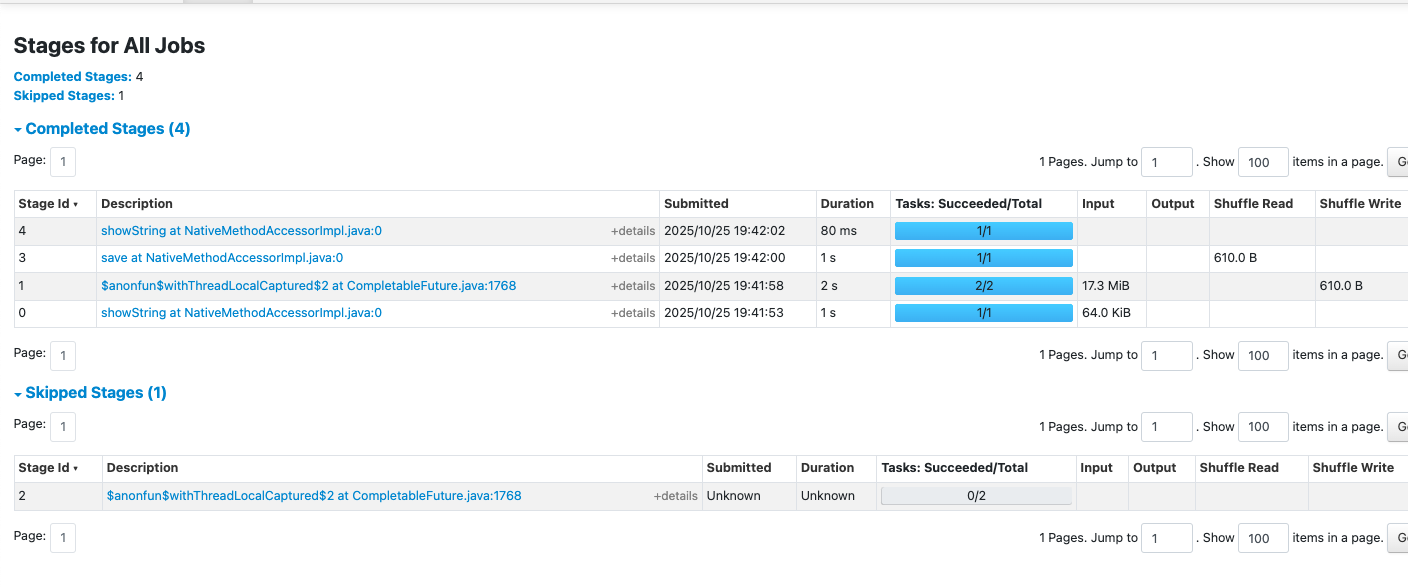

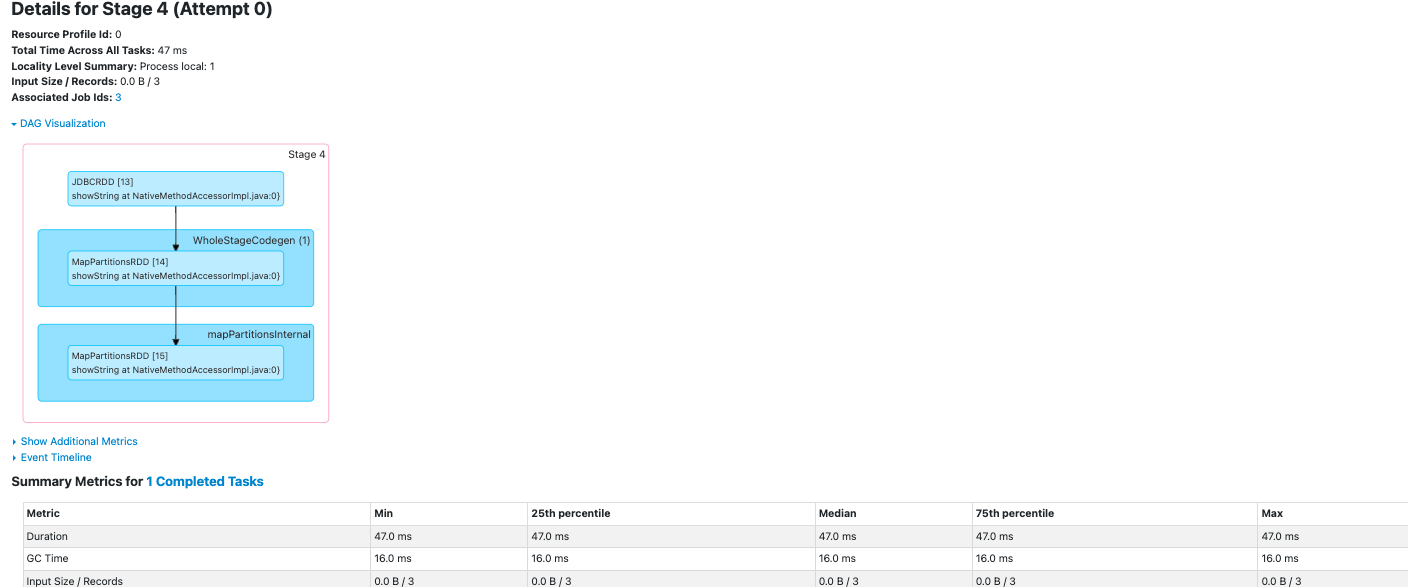

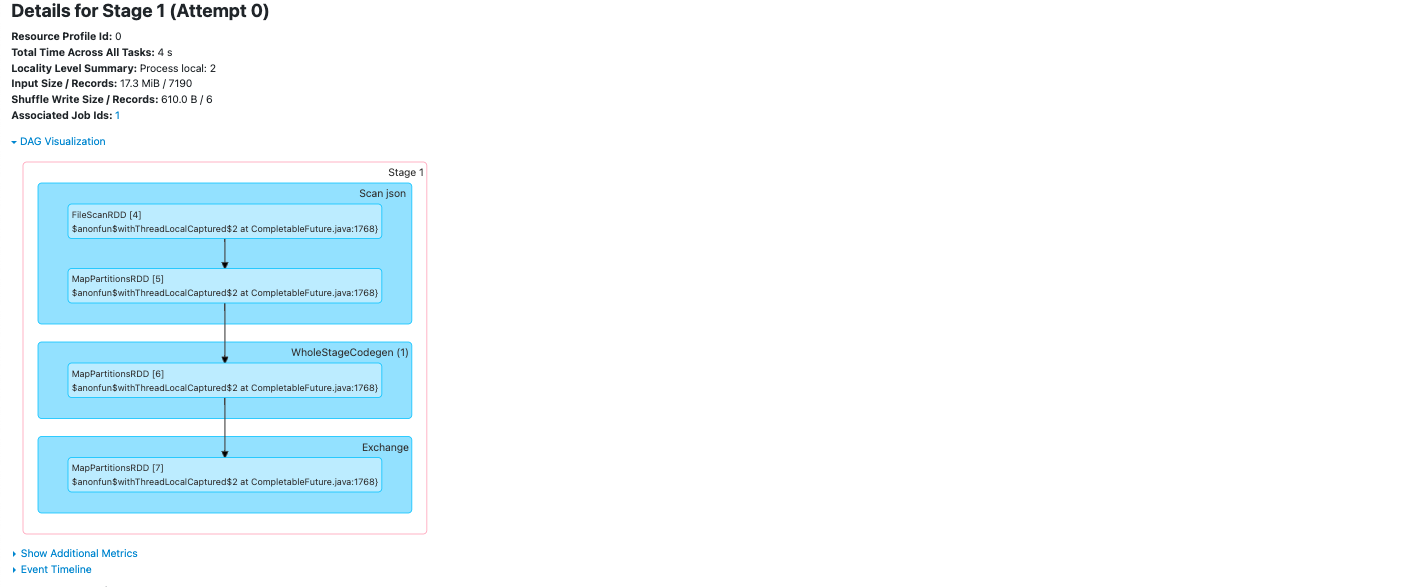